In [1]:
'''
inspired by:
https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code
https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns
'''
import pandas as pd
import time
import numpy as np
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# Based on the information after loading all the data:
n_train_all = 184903891
n_test_all = 18790469
# the subset size that we will be working on:
n_train_sub = 40000000
n_test_sub = n_test_all
validation_percent = 5

In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
print('loading training data...')
train_df = pd.read_csv("../input/train.csv", skiprows=range(1,n_train_all-n_train_sub), nrows=n_train_sub, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

print('loading testing data...')
test_df = pd.read_csv("../input/test.csv", nrows=n_test_sub, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

print('done loading.')

loading training data...
loading testing data...
done loading.


In [5]:
# set the right data types
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')
train_df['click_time'] = pd.to_datetime(train_df['click_time'])
test_df['click_time'] = pd.to_datetime(test_df['click_time'])
train_df['is_attributed'] = train_df['is_attributed'].astype('category')

In [6]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,33924,15,1,19,111,2017-11-09 04:03:08,0
1,37383,3,1,13,280,2017-11-09 04:03:08,0
2,122294,15,1,10,245,2017-11-09 04:03:08,0
3,73258,9,1,25,145,2017-11-09 04:03:08,0
4,73347,15,1,13,430,2017-11-09 04:03:08,0


In [7]:
train_df.describe()

,ip,app,device,os,channel,click_time,is_attributed
count,40000000.0,40000000.0,40000000.0,40000000.0,40000000.0,40000000,40000000.0
unique,104523.0,469.0,2192.0,443.0,185.0,43013,2.0
top,5348.0,3.0,1.0,19.0,107.0,2017-11-09 12:00:11,0.0
freq,318367.0,6198926.0,37343882.0,9368370.0,2304914.0,1471,39899492.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-09 04:03:08,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,NaN


In [8]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [9]:
test_df.describe(include='category')

,ip,app,device,os,channel
count,18790469,18790469,18790469,18790469,18790469
unique,93936,417,1985,395,178
top,5348,9,1,19,107
freq,182522,2872176,17360269,4334532,1214650


In [10]:
is_attributed_train = train_df[train_df.is_attributed == 1]
print("number of downloads in training set: {} ({} percent)".format(len(is_attributed_train), len(is_attributed_train)*100/n_train_sub))

number of downloads in training set: 100508 (0.25127 percent)


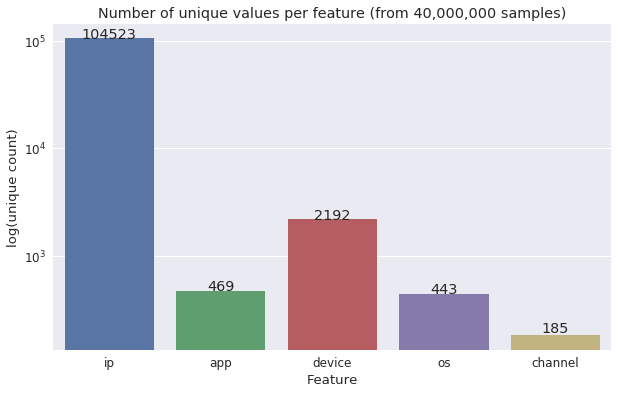

In [14]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 40,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 


In [25]:
train_ip_counts = train_df['ip'].value_counts().reset_index(name='counts')
train_ip_counts.columns = ['ip', 'counts']
train_ip_counts[:10]

,ip,counts
0,5348,318367
1,5314,284299
2,73516,155728
3,73487,154130
4,53454,116348
5,112302,114715
6,17149,113777
7,26995,97968
8,114276,95276
9,95766,90304


In [26]:
train_df = train_df.merge(train_ip_counts, on='ip', how = 'left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


In [31]:
train_df[train_df['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,is_attributed,counts
5199985,5348,19,0,24,347,2017-11-09 05:21:27,1,318367
34226995,5348,29,1,13,210,2017-11-09 14:11:40,1,318367
27602051,5348,8,1,19,145,2017-11-09 12:16:07,1,318367
16441483,5348,24,1,1,178,2017-11-09 08:46:39,1,318367
32302492,5348,18,1,19,107,2017-11-09 13:38:50,1,318367
34210984,5348,19,0,21,213,2017-11-09 14:11:24,1,318367
34211200,5348,19,0,50,213,2017-11-09 14:11:24,1,318367
17644548,5348,136,0,21,268,2017-11-09 09:11:47,1,318367
4740169,5348,19,0,0,347,2017-11-09 05:13:59,1,318367
19870500,5348,19,0,0,347,2017-11-09 09:56:27,1,318367


In [32]:
train_ip_counts_attributed = train_df[train_df['is_attributed']==1]['ip'].value_counts().reset_index(name='counts')
train_ip_counts_attributed.columns = ['ip', 'counts_attributed']
train_ip_counts_attributed[:10]

,ip,counts_attributed
0,5348,525
1,5314,508
2,73516,244
3,73487,237
4,110300,196
5,5178,167
6,5147,132
7,95766,120
8,119531,89
9,26995,81


In [33]:
train_ip_counts[:10]

,ip,counts
0,5348,318367
1,5314,284299
2,73516,155728
3,73487,154130
4,53454,116348
5,112302,114715
6,17149,113777
7,26995,97968
8,114276,95276
9,95766,90304


In [36]:
train_ip[:10]

,ip,counts,counts_attributed
0,5348,318367,525
1,5314,284299,508
2,73516,155728,244
3,73487,154130,237
4,53454,116348,39
5,112302,114715,54
6,17149,113777,52
7,26995,97968,81
8,114276,95276,15
9,95766,90304,120


In [34]:
train_ip = train_ip_counts.merge(train_ip_counts_attributed, on='ip', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'unsigned long'


In [71]:
train_sample = pd.read_csv('../input/train_sample.csv')
train_sample['click_time'] = pd.to_datetime(train_sample['click_time'])
train_sample['attributed_time'] = pd.to_datetime(train_sample['attributed_time'])
#round the hour
train_sample['click_hour'] = train_sample['click_time'].dt.round('H')  

In [72]:
train_sample_count_clickHour = train_sample[['click_hour','is_attributed']].groupby(by = 'click_hour').count().reset_index().rename(columns = {'is_attributed':'count'})

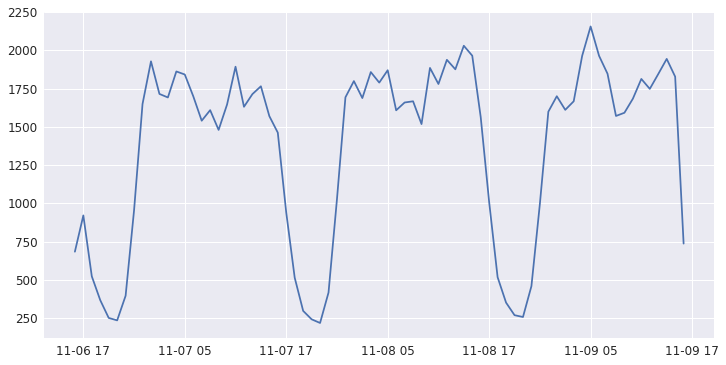

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(train_sample_count_clickHour['click_hour'],train_sample_count_clickHour['count'])

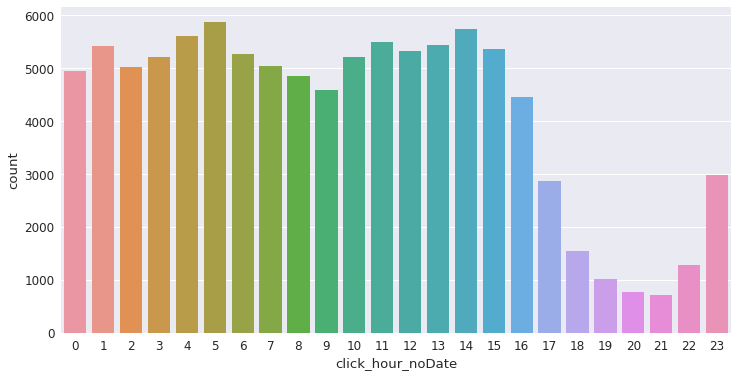

In [77]:
train_sample_count_clickHour['click_hour_noDate'] = train_sample_count_clickHour['click_hour'].dt.hour
new_clickHour = train_sample_count_clickHour[['click_hour_noDate','count']].groupby(by='click_hour_noDate').sum().reset_index()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='click_hour_noDate',y='count',data=new_clickHour)

In [100]:
train_sample['click_hour_noDate'] = train_sample['click_hour'].dt.hour
train_sample_attributed = train_sample[['click_hour_noDate','is_attributed']].groupby(by = 'click_hour_noDate').mean().reset_index().rename(columns = {'is_attributed':'mean'})

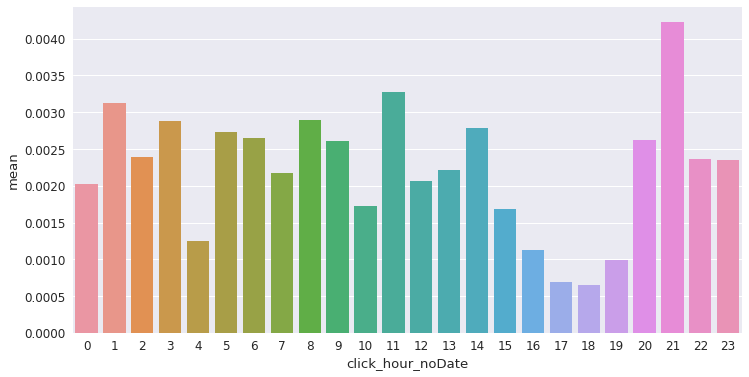

In [101]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='click_hour_noDate',y='mean',data=train_sample_attributed)